In [1]:
import logging
import os
import sys
from collections import defaultdict
from pathlib import Path
from typing import Dict, List, Literal, Optional, Tuple, Union

import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from matplotlib.axes import Axes as Axes

notebook_path = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"])
project_dir = notebook_path.parent.parent
sys.path.append(str(project_dir))
import src.utils.custom_log as custom_log
from src.utils.CfCFilter import CfCFilter
from src.utils.Csv import Csv
from src.utils.iso18571 import rating_iso_18571
from src.utils.ReadBinout import ReadBinout
from src.utils.set_rcparams import set_rcparams
from src.utils.UnifySignal import UnifySignal

os.chdir(project_dir)
LOG = logging.getLogger(__name__)
custom_log.init_logger(logging.INFO)
LOG.info("Log initialized")

set_rcparams()

2025-01-03 22:05:27,088     INFO  MainProcess  MainThread Log initialized
2025-01-03 22:05:27,090     INFO  MainProcess  MainThread Setting rcparams for matplotlib
2025-01-03 22:05:27,137     INFO  MainProcess  MainThread Using style src/visualization/dissertation.mplstyle


In [15]:
B_PATH: Path = Path("/mnt") / "q" / "Val_Chain_Sims" / "AB_Testing" / "PAB_Reduced_Env" / "Steps"
LOG.info("Base path: %s %s", B_PATH, B_PATH.is_dir())
VERSIONS: List[str] = [
    "Stand_PAB_Orig",
    "Stand_PAB_Simple",
    # "Stand_PAB_Simple_Delay",
]
VERSION_NAMES: Dict[str, str] = {
    VERSIONS[0]: "Original PAB in Stand Test",
    VERSIONS[1]: "Simplified PAB in Stand Test",
    # VERSIONS[2]: "Simplified Delayed",
}

2025-01-03 22:14:39,449     INFO  MainProcess  MainThread Base path: /mnt/q/Val_Chain_Sims/AB_Testing/PAB_Reduced_Env/Steps True


### Get Data

In [16]:
def get_data() -> pd.DataFrame:
    unifier = UnifySignal(target_sampling_rate_ms=0.1, target_tend_ms=130, target_tstart_ms=15)
    fields = {
        "abstat": (
            "pressure",
            "volume",
            "total_mass",
            "gas_temp",
            "dm_dt_in",
            "dm_dt_out",
        ),
        "glstat": (
            "total_energy",
            "added_mass",
            "kinetic_energy",
            "internal_energy",
            "sliding_interface_energy",
            "time_step",
            "hourglass_energy",
        ),
    }
    dbs = []
    for version in VERSIONS:
        LOG.info(f"Reading {version}")
        with ReadBinout(sim_dir=B_PATH / version) as binout:
            db_version = []
            for field, channels in fields.items():
                db = pd.DataFrame(index=binout.binout.read(field, "time") * 1000)
                for key in channels:
                    db[key] = binout.binout.read(field, key)
                db = unifier.unify(db=db)
                db_version.append(db)
            db_version = pd.concat(db_version, axis=1)
            db_version["version"] = [VERSION_NAMES[version]] * db_version.shape[0]
            dbs.append(db_version.copy())

    dbs = pd.concat(dbs, axis=0)
    dbs["Time [ms]"] = dbs.index
    return dbs


DB = get_data()
DB

2025-01-03 22:14:40,927     INFO  MainProcess  MainThread Reading Stand_PAB_Orig
2025-01-03 22:14:40,944     INFO  MainProcess  MainThread Process simulation from /mnt/q/Val_Chain_Sims/AB_Testing/PAB_Reduced_Env/Steps/Stand_PAB_Orig in /tmp/Stand_PAB_Orig_srxx2736
2025-01-03 22:14:43,442     INFO  MainProcess  MainThread Opened ['/tmp/Stand_PAB_Orig_srxx2736/binout0000', '/tmp/Stand_PAB_Orig_srxx2736/binout0003']
2025-01-03 22:14:43,706     INFO  MainProcess  MainThread Reading Stand_PAB_Simple
2025-01-03 22:14:43,711     INFO  MainProcess  MainThread Process simulation from /mnt/q/Val_Chain_Sims/AB_Testing/PAB_Reduced_Env/Steps/Stand_PAB_Simple in /tmp/Stand_PAB_Simple_whqheywf
2025-01-03 22:14:45,467     INFO  MainProcess  MainThread Opened ['/tmp/Stand_PAB_Simple_whqheywf/binout0000', '/tmp/Stand_PAB_Simple_whqheywf/binout0003']


,dm_dt_in,dm_dt_out,gas_temp,pressure,total_mass,volume,added_mass,hourglass_energy,internal_energy,kinetic_energy,sliding_interface_energy,time_step,total_energy,version,Time [ms]
15.0,-1.229375e-11,-8.032067e-10,294.017822,0.101298,0.000002,8.816327e+05,3.097270e-10,0.0,1.280527e+00,3.830587,-0.600226,6.300000e-07,4.510895e+00,Original PAB in Stand Test,15.0
15.1,-1.022525e-06,-2.582090e-06,294.017881,0.101259,0.000002,8.816023e+05,3.097270e-10,0.0,1.299729e+00,3.872650,-0.603522,6.300000e-07,4.568860e+00,Original PAB in Stand Test,15.1
15.2,-3.623434e-06,-8.763474e-06,294.018016,0.101204,0.000002,8.815665e+05,3.097270e-10,0.0,1.324263e+00,3.898758,-0.608743,6.300000e-07,4.614278e+00,Original PAB in Stand Test,15.2
15.3,-7.125141e-06,-1.695707e-05,294.018212,0.101142,0.000002,8.815261e+05,3.097270e-10,0.0,1.343791e+00,3.938762,-0.615046,6.300000e-07,4.667508e+00,Original PAB in Stand Test,15.3
15.4,-1.085005e-05,-2.557499e-05,294.018458,0.101082,0.000002,8.814821e+05,3.097270e-10,0.0,1.361146e+00,3.988352,-0.619774,6.300000e-07,4.729718e+00,Original PAB in Stand Test,15.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129.6,0.000000e+00,2.954980e-05,680.379778,0.101336,0.000029,6.291006e+07,0.000000e+00,0.0,2.855020e+06,252.608981,1863.354562,1.341138e-06,2.857136e+06,Simplified PAB in Stand Test,129.6
129.7,0.000000e+00,3.129772e-05,680.385633,0.101340,0.000029,6.290252e+07,0.000000e+00,0.0,2.855020e+06,253.177167,1863.598354,1.341138e-06,2.857136e+06,Simplified PAB in Stand Test,129.7
129.8,0.000000e+00,3.273599e-05,680.390749,0.101343,0.000029,6.289515e+07,0.000000e+00,0.0,2.855020e+06,253.187851,1863.561476,1.341138e-06,2.857136e+06,Simplified PAB in Stand Test,129.8
129.9,0.000000e+00,3.371860e-05,680.394697,0.101346,0.000029,6.288801e+07,0.000000e+00,0.0,2.855020e+06,252.797648,1863.557513,1.341138e-06,2.857137e+06,Simplified PAB in Stand Test,129.9


In [17]:
def get_isos() -> pd.DataFrame:
    isos = defaultdict(dict)
    for channel in ("dm_dt_in", "dm_dt_out", "gas_temp", "pressure", "total_mass", "volume"):
        for version in DB["version"].unique():
            if version != "Original":
                LOG.info(f"Calculating ISO for {channel} in {version}")
                isos[channel][version] = rating_iso_18571(
                    signal_ref=DB[channel][DB["version"].eq("Original")].to_numpy(),
                    signal_comp=DB[channel][DB["version"].eq(version)].to_numpy(),
                )["ISO 18571 Rating"]

    return pd.DataFrame(isos)


ISOS = get_isos()
ISOS

2025-01-03 22:14:47,454     INFO  MainProcess  MainThread Calculating ISO for dm_dt_in in Original PAB in Stand Test


ValueError: zero-size array to reduction operation minimum which has no identity

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching TeX Gyre Heros:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\plaschkies\\Documents\\Py_Projects\\aihiii\\.conda\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\plaschkies\\Documents\\Py_Projects\\aihiii\\.conda\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findf

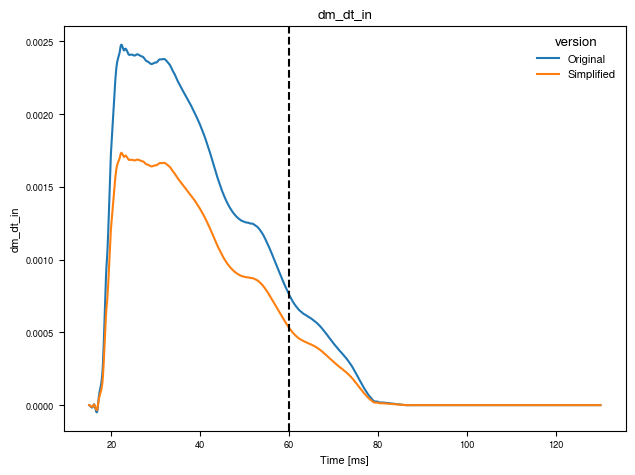

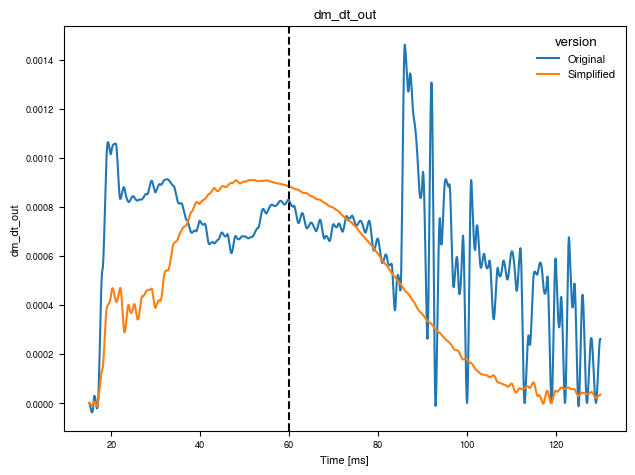

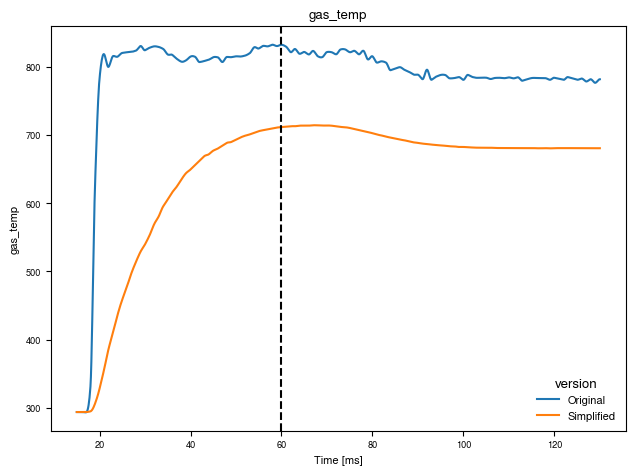

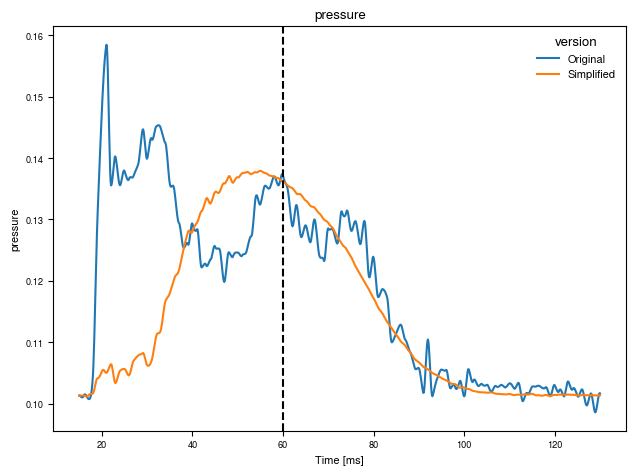

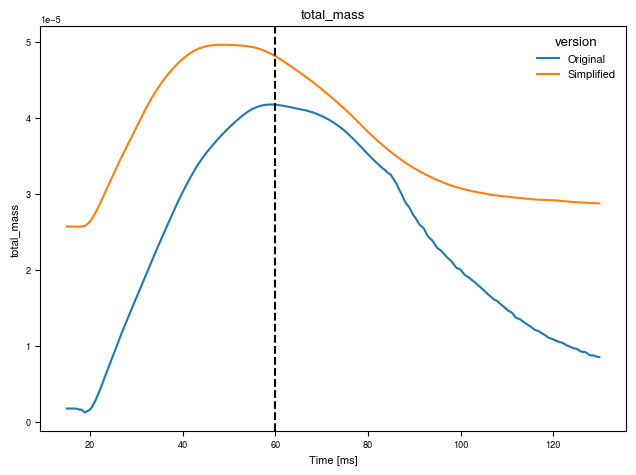

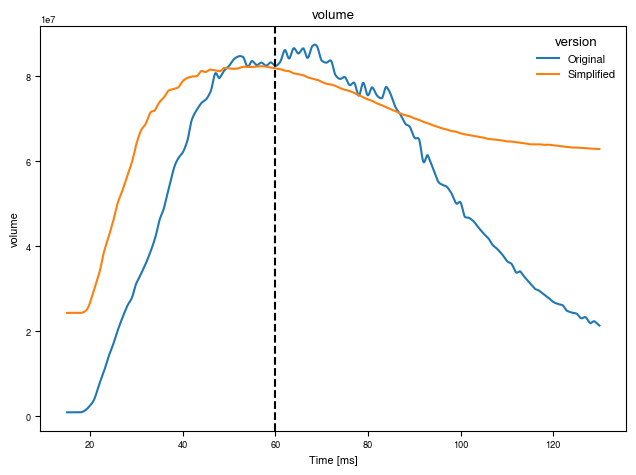

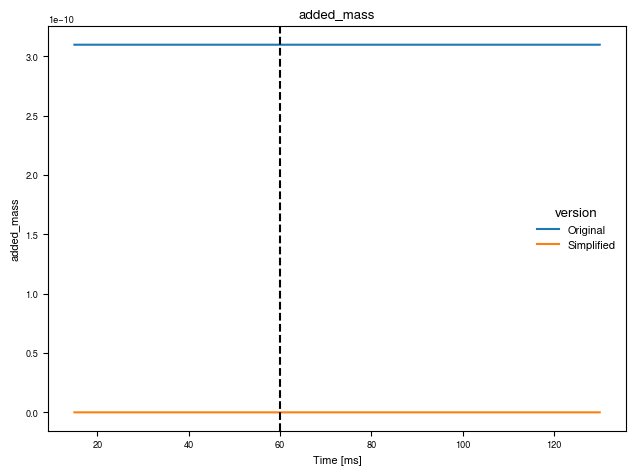

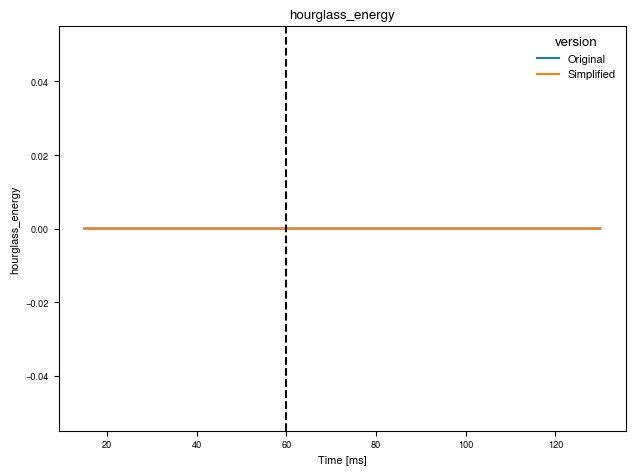

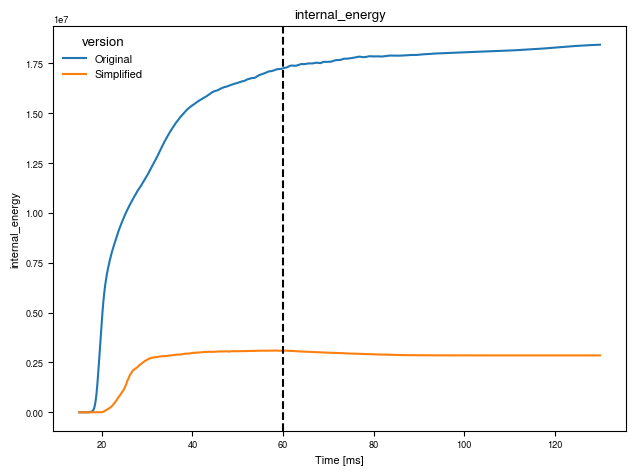

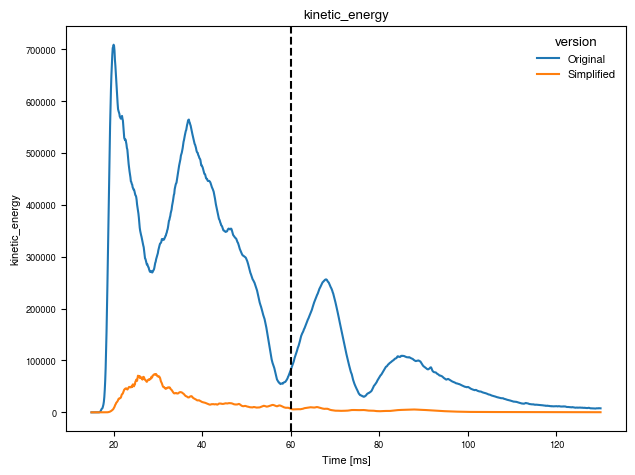

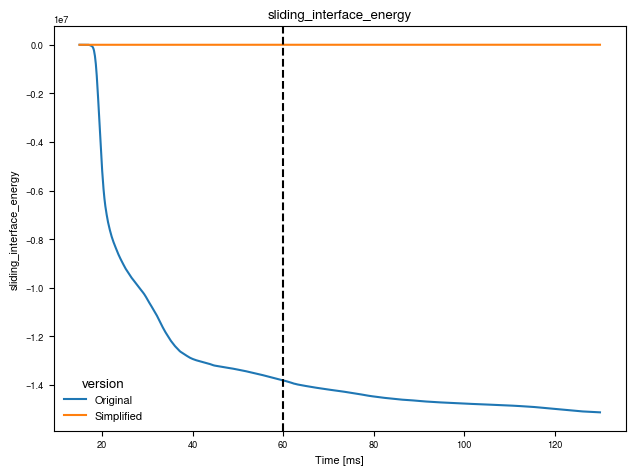

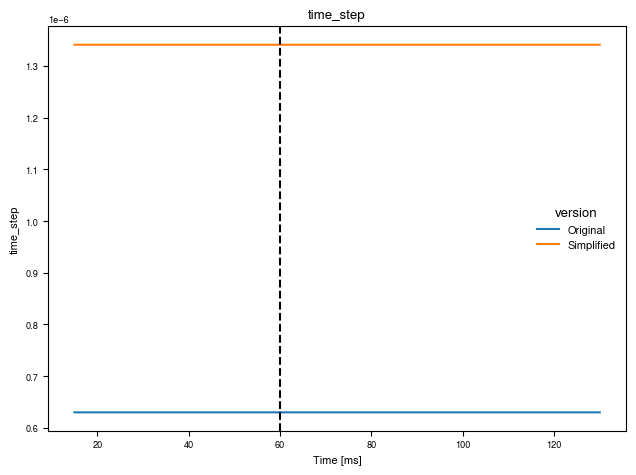

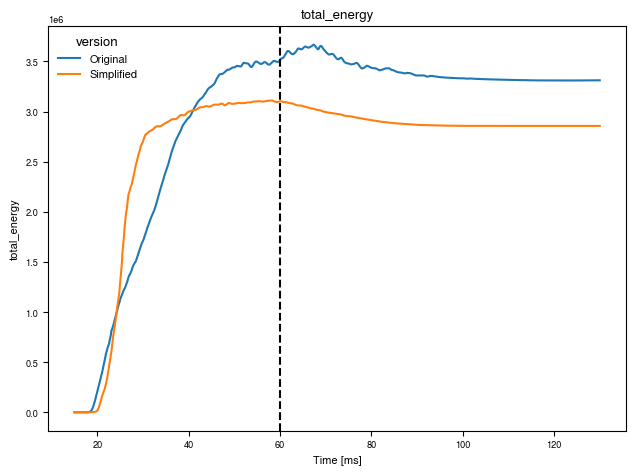

In [5]:
for ch in DB.columns:
    if ch not in {"Time [ms]", "version"}:
        fig, ax = plt.subplots()
        sns.lineplot(data=DB, x="Time [ms]", y=ch, hue="version", ax=ax)
        ax.set_title(ch)
        ax.axvline(60, color="black", linestyle="--")

2025-01-03 22:15:01,058     INFO  MainProcess  MainThread maxp pruned
2025-01-03 22:15:01,065     INFO  MainProcess  MainThread cmap pruned
2025-01-03 22:15:01,067     INFO  MainProcess  MainThread post pruned
2025-01-03 22:15:01,069     INFO  MainProcess  MainThread CFF  pruned
2025-01-03 22:15:01,075     INFO  MainProcess  MainThread GPOS pruned
2025-01-03 22:15:01,084     INFO  MainProcess  MainThread GSUB pruned
2025-01-03 22:15:01,086     INFO  MainProcess  MainThread Added .notdef to subset
2025-01-03 22:15:01,088     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 40 glyphs before
2025-01-03 22:15:01,089     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'A', 'B', 'F', 'I', 'M', 'O', 'P', 'S', 'T', 'V', 'a', 'b', 'bracketleft', 'bracketright', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'i', 'l', 'm', 'n', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'slash', 'space', 't', 'two', 'u', 'w', 'zero']
2025-01-03 22:15:01,091     INFO  MainProcess  MainThread Gl

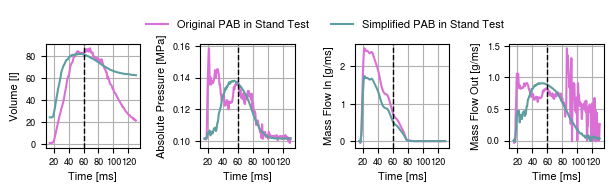

In [18]:
def plot():
    fig_width: float = 1 * (448.13095 / 72) -0.2
    fig_height = 0.3 * fig_width
    chs = ["volume", "pressure", "dm_dt_in", "dm_dt_out"]
    fig, ax = plt.subplot_mosaic(
        mosaic=[["L"]*4, chs],
        sharex=True,
        layout="constrained",
        height_ratios=[0.1,1],
    )
    db = DB.copy()
    for ch in chs:
        if ch == "volume":
            db[ch] *= 1e-6
        elif "dm" in ch:
            db[ch] *= 1e3
        g = sns.lineplot(data=db, x="Time [ms]", y=ch, hue="version", ax=ax[ch], palette=["orchid", "cadetblue"])
        ax[ch].legend().remove()
        ax[ch].axvline(60, color="black", linestyle="--", lw=1)
        ax[ch].grid()

        ax[ch].set_ylabel(
            {
                "volume": "Volume [l]",
                "pressure": "Absolute Pressure [MPa]",
                "dm_dt_in": "Mass Flow In [g/ms]",
                "dm_dt_out": "Mass Flow Out [g/ms]",
            }[ch]
        )
        ax[ch].set_xticks(np.arange(20, 121, 20))

    ax["L"].axis("off")
    ax["L"].legend(*ax[ch].get_legend_handles_labels(), loc="upper center", ncol=2)
    fig.set_figheight(fig_height)
    fig.set_figwidth(fig_width)
    fig.savefig(Path("reports") / "pab_stand_test_comp.pdf")


plot()